In [1]:
import numpy as np
import nibabel as nib
from nilearn.plotting import plot_surf_stat_map
from matplotlib import pyplot as plt
import pandas as pd

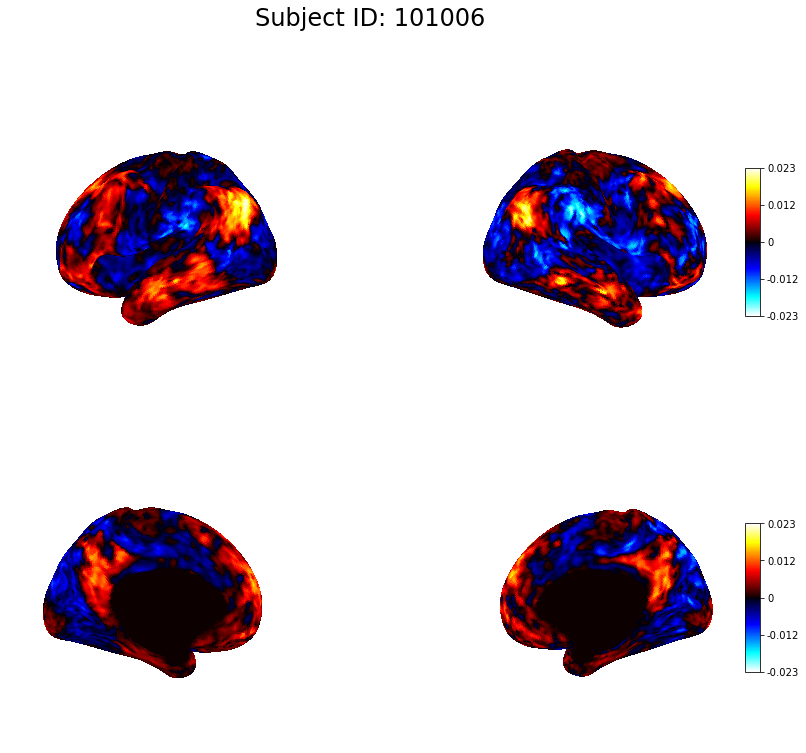

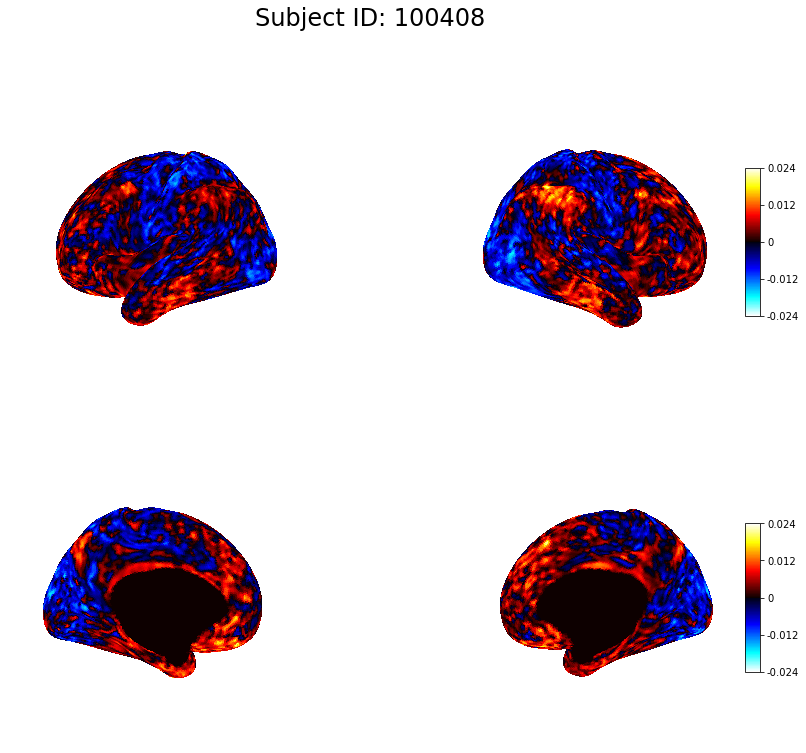

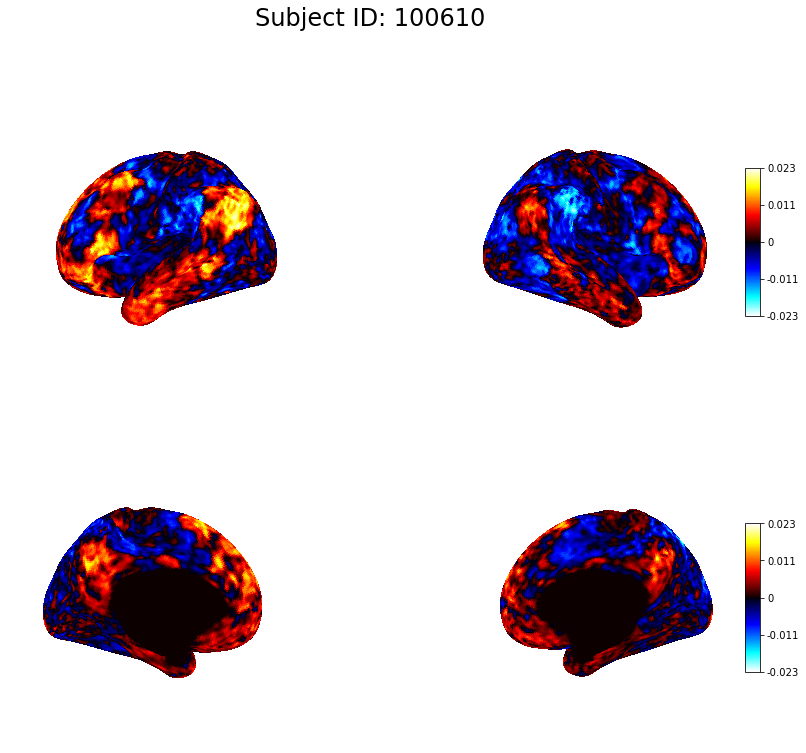

In [35]:
for sub in np.load('/home/fralberti/Data/Concatenated_dtseries/subject_IDs.npy'):
    grad1 = nib.load('/home/fralberti/Data/Gradient_1/%s_grad1.dscalar.nii' % sub)
    fig, axs = plt.subplots(2, 2, figsize=(15,12), subplot_kw={'projection':'3d'}, sharey=True)
    
    for i, hemi in enumerate(['L','R']):
        hemisphere = ['left','right']
        surf = nib.load('/home/fralberti/Data/HCP_zone_prim/%s/%s.%s.midthickness_MSMAll.32k_fs_LR.surf.gii' % (sub,sub,hemi))
        
        idx_count = grad1.header.get_index_map(1)[i].index_count
        idx_offset = grad1.header.get_index_map(1)[i].index_offset
        vtx_indices = grad1.header.get_index_map(1)[i].vertex_indices[0:]
        stat_map = np.zeros(surf.agg_data()[0].shape[0])
        stat_map[vtx_indices] = np.asanyarray(grad1.get_fdata().squeeze()[idx_offset:idx_offset+idx_count])*-1

        
        plot_surf_stat_map('/home/fralberti/Data/HCP_S1200_Group_Avg_v1/HCP_S1200_GroupAvg_v1/S1200.%s.inflated_MSMAll.32k_fs_LR.surf.gii' % hemi,
                           stat_map, hemi=hemisphere[i], axes=axs[0,i],colorbar=i)
        plot_surf_stat_map('/home/fralberti/Data/HCP_S1200_Group_Avg_v1/HCP_S1200_GroupAvg_v1/S1200.%s.inflated_MSMAll.32k_fs_LR.surf.gii' % hemi,
                           stat_map, hemi=hemisphere[i], view='medial', axes=axs[1,i],colorbar=i)
        fig.suptitle('Subject ID: %s' % sub, fontsize=24)
        del surf
    del grad1
